In [22]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv("df.csv")
print(df.head())

   Corporation ID                         Corp Name  Non-GCE Promote %  \
0              15   Adams Central Community Schools           0.017691   
1              25     North Adams Community Schools           0.042012   
2              35               South Adams Schools           0.004467   
3             125  MSD Southwest Allen County Schls           0.024144   
4             225    Northwest Allen County Schools           0.012208   

      ELL %  Special Education %    FRPM_%  Pct American Indian  Pct Asian  \
0  0.023529             0.152941  0.271324             0.000735   0.005147   
1  0.007600             0.179861  0.454718             0.002533   0.005066   
2  0.100153             0.188838  0.455657             0.001529   0.008410   
3  0.020649             0.119391  0.236400             0.002250   0.046195   
4  0.036025             0.157700  0.237743             0.001193   0.062865   

   Pct Black  Pct Hispanic  ...  Pct Pacific Islander  Pct White  \
0   0.005882      

## Digging into the Chronically Absent Percent and FRPM_% relationship

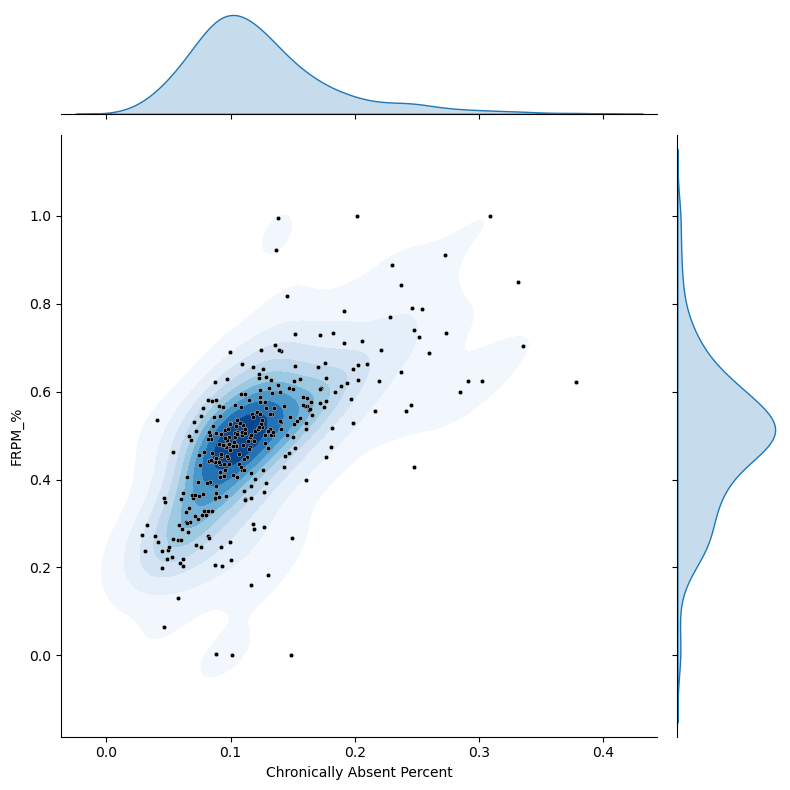

In [24]:
sns.jointplot(
    data=df,
    x="Chronically Absent Percent",
    y="FRPM_%",
    kind="kde", 
    fill=True,  
    cmap="Blues", 
    height=8
).plot_joint(sns.scatterplot, s=10, color='black') 

plt.show()

In [25]:
from scipy.stats import pearsonr

r, p_value = pearsonr(df['Chronically Absent Percent'], df['FRPM_%'])
print(f"Pearson correlation: {r:.2f}, p-value: {p_value:.4f}")

Pearson correlation: 0.66, p-value: 0.0000


In [26]:
df[['Chronically Absent Percent', 'FRPM_%']].describe()

,Chronically Absent Percent,FRPM_%
count,306.000000,306.000000
mean,0.123441,0.489895
std,0.056480,0.160130
min,0.029026,0.000000
25%,0.087361,0.396127
50%,0.111322,0.501525
75%,0.146999,0.578386
max,0.378023,1.000000


In [27]:
# Get the 75th percentiles
q75_absent = df['Chronically Absent Percent'].quantile(0.75)
q75_frpm = df['FRPM_%'].quantile(0.75)

# Create Boolean masks
high_absent = df['Chronically Absent Percent'] > q75_absent
high_frpm = df['FRPM_%'] > q75_frpm

# Combine conditions
both_high = high_absent & high_frpm
only_absent = high_absent & ~high_frpm
only_frpm = ~high_absent & high_frpm
neither = ~high_absent & ~high_frpm

# Count rows in each category
print("Both high:", both_high.sum())
print("Only Chronically Absent Percent high:", only_absent.sum())
print("Only FRPM_% high:", only_frpm.sum())
print("Neither high:", neither.sum()) 

Both high: 48
Only Chronically Absent Percent high: 29
Only FRPM_% high: 29
Neither high: 200


Encoding labels for original df:
- 0: neither
- 1: Only high in absenteeism
- 2: Only high in FRPM
- 3: high in both

In [28]:
def encode_group(row):
    if row['Chronically Absent Percent'] > q75_absent and row['FRPM_%'] > q75_frpm:
        return 3
    elif row['Chronically Absent Percent'] > q75_absent:
        return 1
    elif row['FRPM_%'] > q75_frpm:
        return 2
    else:
        return 0

df['absent-frpm_label'] = df.apply(encode_group, axis=1)

In [29]:
group_means = df.groupby('absent-frpm_label').mean(numeric_only=True)
print(group_means)

                   Corporation ID  Non-GCE Promote %     ELL %  \
absent-frpm_label                                                
0                     4584.425000           0.021408  0.031971   
1                     5739.482759           0.048363  0.044907   
2                     5045.000000           0.032807  0.096795   
3                     5915.416667           0.063288  0.092799   

                   Special Education %    FRPM_%  Pct American Indian  \
absent-frpm_label                                                       
0                             0.170379  0.415150             0.001680   
1                             0.195267  0.498300             0.001561   
2                             0.172340  0.658373             0.001711   
3                             0.211621  0.694466             0.001274   

                   Pct Asian  Pct Black  Pct Hispanic  Pct Multiracial  \
absent-frpm_label                                                        
0               

   Non-GCE Promote %     ELL %  Special Education %    FRPM_%  \
0           0.017691  0.023529             0.152941  0.271324   
1           0.042012  0.007600             0.179861  0.454718   
2           0.004467  0.100153             0.188838  0.455657   
3           0.024144  0.020649             0.119391  0.236400   
4           0.012208  0.036025             0.157700  0.237743   

   Chronically Absent Percent  AVG_ATT_RATE  Total Enrollment  \
0                    0.038941      0.966399              1360   
1                    0.092294      0.973404              1579   
2                    0.074315      0.957031              1308   
3                    0.031000      0.994553              7555   
4                    0.044749      0.961639              8383   

   Corp Per/Student  % Tested ELA  % Tested Math  Pct American Indian  \
0           9659.39      0.437500       0.437500             0.000735   
1          12311.39      0.346422       0.345155             0.002533   

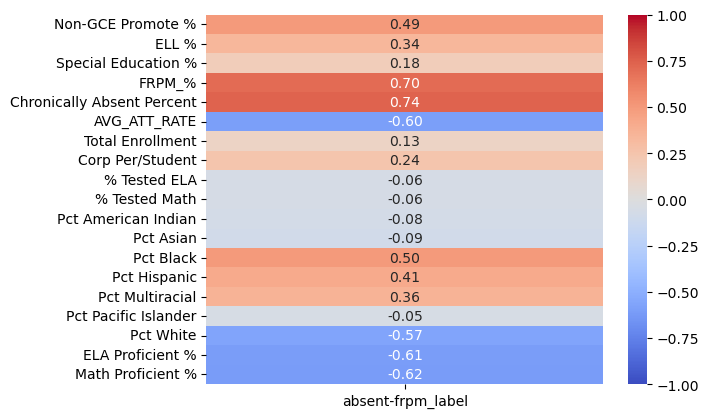

In [31]:
temp_df = df.copy()
temp_df['both_high_flag'] = (df['absent-frpm_label'] == 3).astype(int)

X = ["Non-GCE Promote %", 
     "ELL %", 
     "Special Education %", 
     "FRPM_%",  
     "Chronically Absent Percent", 
     "AVG_ATT_RATE", 
     "Total Enrollment", 
     "Corp Per/Student", 
     "% Tested ELA", 
     "% Tested Math",
     "Pct American Indian",
     "Pct Asian",
     "Pct Black",
     "Pct Hispanic",
     "Pct Multiracial",
     "Pct Pacific Islander",
     "Pct White",
     "ELA Proficient %", 
     "Math Proficient %"]
Y = ["absent-frpm_label"]
subset = df[X + Y]
print(subset.head())
corrs = subset.corr().loc[X, Y]
feature_label_corr_map = plt.figure()
sns.heatmap(corrs, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.show()

## Digging into the Chronically Absent Percent and Non-GCE Promote % relationship

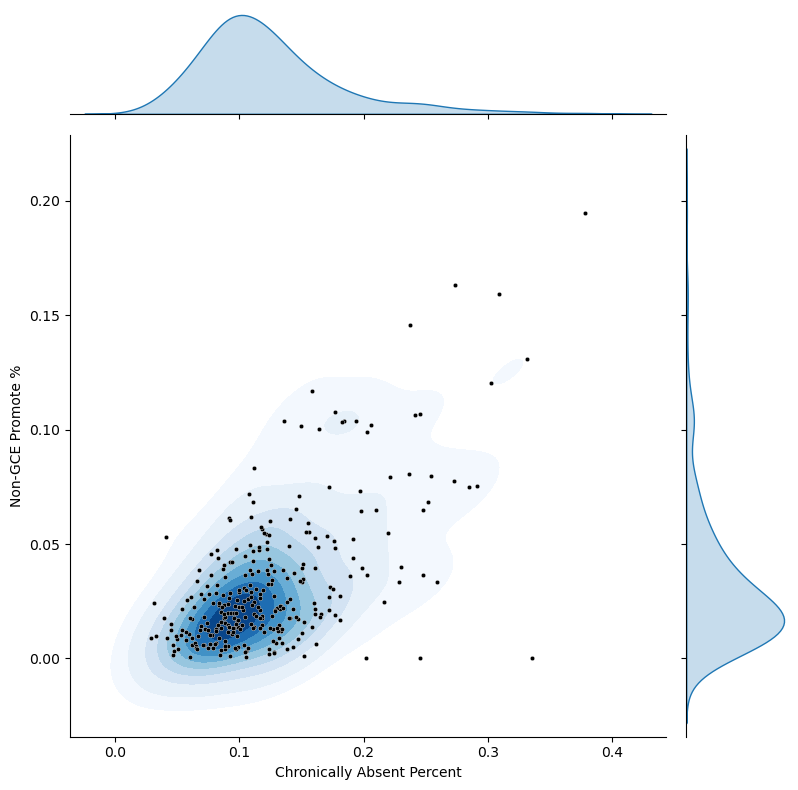

In [32]:
sns.jointplot(
    data=df,
    x="Chronically Absent Percent",
    y="Non-GCE Promote %",
    kind="kde", 
    fill=True,  
    cmap="Blues", 
    height=8
).plot_joint(sns.scatterplot, s=10, color='black') 

plt.show()

In [33]:
from scipy.stats import pearsonr

r, p_value = pearsonr(df['Chronically Absent Percent'], df['Non-GCE Promote %'])
print(f"Pearson correlation: {r:.2f}, p-value: {p_value:.4f}")

Pearson correlation: 0.63, p-value: 0.0000


In [34]:
df[['Chronically Absent Percent', 'Non-GCE Promote %']].describe()

,Chronically Absent Percent,Non-GCE Promote %
count,306.000000,306.000000
mean,0.123441,0.031612
std,0.056480,0.029637
min,0.029026,0.000000
25%,0.087361,0.012801
50%,0.111322,0.022583
75%,0.146999,0.039837
max,0.378023,0.194760


In [35]:
# Get the 75th percentiles
q75_absent = df['Chronically Absent Percent'].quantile(0.75)
q75_promote = df['Non-GCE Promote %'].quantile(0.75)

# Create Boolean masks
high_absent = df['Chronically Absent Percent'] > q75_absent
high_promote = df['Non-GCE Promote %'] > q75_promote

# Combine conditions
both_high = high_absent & high_promote
only_absent = high_absent & ~high_promote
only_promote = ~high_absent & high_promote
neither = ~high_absent & ~high_promote

# Count rows in each category
print("Both high:", both_high.sum())
print("Only Chronically Absent Percent high:", only_absent.sum())
print("Only Non-GCE Promote % high:", only_promote.sum())
print("Neither high:", neither.sum()) 

Both high: 43
Only Chronically Absent Percent high: 34
Only Non-GCE Promote % high: 34
Neither high: 195


Encoding labels for original df:
- 0: neither
- 1: Only high in absenteeism
- 2: Only high in Non-GCE Promote rate
- 3: high in both

In [36]:
def encode_absent_promote_group(row):
    if row['Chronically Absent Percent'] > q75_absent and row['Non-GCE Promote %'] > q75_promote:
        return 3
    elif row['Chronically Absent Percent'] > q75_absent:
        return 1
    elif row['Non-GCE Promote %'] > q75_promote:
        return 2
    else:
        return 0

df['absent-promote_label'] = df.apply(encode_absent_promote_group, axis=1)

In [37]:
group_means = df.groupby('absent-promote_label').mean(numeric_only=True)
print(group_means)

                      Corporation ID  Non-GCE Promote %     ELL %  \
absent-promote_label                                                
0                        4686.076923           0.017352  0.035340   
1                        6017.647059           0.022623  0.040749   
2                        4394.264706           0.054394  0.067942   
3                        5715.930233           0.085376  0.101656   

                      Special Education %    FRPM_%  Pct American Indian  \
absent-promote_label                                                       
0                                0.170345  0.429531             0.001679   
1                                0.230204  0.584242             0.001225   
2                                0.172244  0.540127             0.001715   
3                                0.185898  0.649323             0.001506   

                      Pct Asian  Pct Black  Pct Hispanic  Pct Multiracial  \
absent-promote_label                               

   Non-GCE Promote %     ELL %  Special Education %    FRPM_%  \
0           0.017691  0.023529             0.152941  0.271324   
1           0.042012  0.007600             0.179861  0.454718   
2           0.004467  0.100153             0.188838  0.455657   
3           0.024144  0.020649             0.119391  0.236400   
4           0.012208  0.036025             0.157700  0.237743   

   Chronically Absent Percent  AVG_ATT_RATE  Total Enrollment  \
0                    0.038941      0.966399              1360   
1                    0.092294      0.973404              1579   
2                    0.074315      0.957031              1308   
3                    0.031000      0.994553              7555   
4                    0.044749      0.961639              8383   

   Corp Per/Student  % Tested ELA  % Tested Math  Pct American Indian  \
0           9659.39      0.437500       0.437500             0.000735   
1          12311.39      0.346422       0.345155             0.002533   

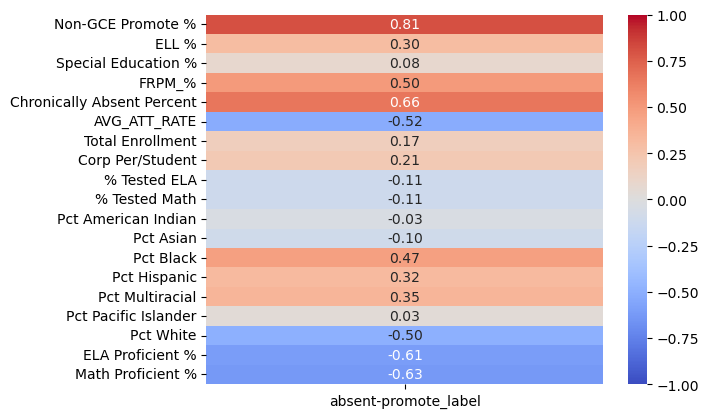

In [38]:
temp_df = df.copy()
temp_df['both_high_flag'] = (df['absent-promote_label'] == 3).astype(int)

X = ["Non-GCE Promote %", 
     "ELL %", 
     "Special Education %", 
     "FRPM_%", 
     "Chronically Absent Percent", 
     "AVG_ATT_RATE", 
     "Total Enrollment", 
     "Corp Per/Student", 
     "% Tested ELA", 
     "% Tested Math",
     "Pct American Indian",
     "Pct Asian",
     "Pct Black",
     "Pct Hispanic",
     "Pct Multiracial",
     "Pct Pacific Islander",
     "Pct White",
     "ELA Proficient %", 
     "Math Proficient %"]
Y = ["absent-promote_label"]
subset = df[X + Y]
print(subset.head())
corrs = subset.corr().loc[X, Y]
feature_label_corr_map = plt.figure()
sns.heatmap(corrs, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.show()